# Setup

In [1]:
!pip install stable-baselines3 gym-anytrading gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 37.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

In [2]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
!pip install mplfinance
!pip install pandas_ta
import mplfinance as mpf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import time
import plotly.graph_objects as go
import math
from sklearn.metrics import classification_report
yf.pdr_override()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=25749dceace5159ca33c4c17a92465ce372629113fa5468e3629a752505106e5
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


# Data Collection


In [ ]:
df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")

In [ ]:
df["Gmt time"] = pd.to_datetime(df["Gmt time"])
df.set_index("Gmt time",inplace = True)

# Feature enginnering

## Target Variables Extraction

In [ ]:
# MAJOR-REVERSAL
def get_maxs(points):
   maxs_index = []
   maxs_value = []
   if len(points) > 2:
     for i in range(1,len(points)-1):
        if points[i] > points[i-1] and points[i] > points[i+1]:
          maxs_index.append(i)
          maxs_value.append(points[i])
   return maxs_index,maxs_value

def get_mins(points,maxs):
    mins = []
    ranges = maxs
    for i in range(len(maxs)-1):
      idxmin_loc = points.iloc[ranges[i]+1:ranges[i+1]].idxmin()
      idx_loc = points.index.get_loc(idxmin_loc)
      mins.append(idx_loc)
    return mins

def get_major_reversals(high_points,low_points):
    maxs_index,maxs_value = get_maxs(high_points)
    max_maxs_index,maxs_value = get_maxs(maxs_value)
    maxs_index = [maxs_index[i] for i in max_maxs_index]
    mins_index = get_mins(low_points,maxs_index)
    return high_points.index[mins_index],high_points.index[maxs_index]

# MINOR-REVERSAL
def before_up_mask(points,avg_candle,factor_1 = 0.9, factor_2 = 0.1):
   return ~( ((points) >= (points.shift(1) + (avg_candle * factor_1)))
          | ( (points.shift(1) < (points - avg_candle * factor_2)) &  (points < (points.shift(-1) - avg_candle * factor_2)) ) )
def next_up_mask(points,avg_candle,factor_1 = 0.9, factor_2 = 0.1):
   return   ( ((points.shift(-1)) >= (points + (avg_candle * factor_1)))
              | ( (points < (points.shift(-1) - avg_candle * factor_2)) &  (points.shift(-1) < (points.shift(-2) - avg_candle * factor_2)) ) )
def is_up(points,avg_candle,factor_1 = 0.9, factor_2 = 0.1):
   return next_up_mask(points,avg_candle) & before_up_mask(points,avg_candle)
def before_down_mask(points,avg_candle,factor_1 = 0.9, factor_2 = 0.1):
   return ~( ((points) <= (points.shift(1) - (avg_candle * factor_1)))
          | ( (points.shift(1) > (points + avg_candle * factor_2)) &  (points > (points.shift(-1) + avg_candle * factor_2)) ) )
def next_down_mask(points,avg_candle,factor_1 = 0.9, factor_2 = 0.1):
   return   ( ((points.shift(-1)) <= (points - (avg_candle * factor_1)))
              | ( (points > (points.shift(-1) + avg_candle * factor_2)) &  (points.shift(-1) > (points.shift(-2) + avg_candle * factor_2)) ) )
def is_down(points,avg_candle):
   return next_down_mask(points,avg_candle) & before_down_mask(points,avg_candle)
def is_steady(high_points,low_points,avg_candle):
  return ~next_up_mask(low_points,avg_candle) & ~next_down_mask(high_points,avg_candle)

def get_minor_reversals(high_points,low_points):
    avg_candle = (high_points - low_points).rolling(window=14).mean()
    down_reversal = high_points[is_down(high_points,avg_candle)].index
    up_reversal = low_points[is_up(low_points,avg_candle)].index
    mask = is_steady(high_points,low_points,avg_candle)
    steady = low_points[mask & ~mask.shift(1).fillna(True)].index
    return up_reversal, down_reversal, steady

# TREND-SHIFT
def find_outliers(chunk, q1 = 0.4, q2 = 0.6):
    Q1 = chunk.quantile(q1)
    Q3 = chunk.quantile(q2)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return chunk[(chunk < lower_bound) | (chunk > upper_bound)]
def get_trend_shift(high_points,low_points):
     avg_hl = (low_points + high_points) / 2
     trend_angle_diff = avg_hl.diff(periods = -1).apply(lambda x: math.degrees(math.atan(x))).diff()
     chunk_size = 200
     trend_angle_diff = trend_angle_diff.reset_index(drop = True)
     group_key = trend_angle_diff.index // chunk_size
     trend_shift = trend_angle_diff.groupby(group_key).apply(find_outliers).reset_index(level=0, drop=True)
     return high_points.index[trend_shift.index]

# Major_Trend (categorical): -1,0,1
def get_major_trend(mins_index,maxs_index,original_idx_list,len_df):
    idx_list = np.insert(original_idx_list, 0, -1, axis=0)
    idx_list = np.append(idx_list, len_df)
    trend_array = np.zeros(len_df)
    trend = -1 if min(mins_index) < min(maxs_index) else 1
    for i in range(len(idx_list)-1):
        trend_array[idx_list[i]+1:idx_list[i+1]] = trend
        trend *= -1
    return trend_array

# Visualize and inspect cause it is not really good
def get_fractals(high , low, period) :
    periods = [p for p in range(-period, period + 1) if p != 0]

    highs = [high > high.shift(p) for p in periods]
    bears = pd.Series(np.logical_and.reduce(highs), index=high.index)
    bears_index = bears[bears == True].index

    lows = [low < low.shift(p) for p in periods]
    bulls = pd.Series(np.logical_and.reduce(lows), index=high.index)
    bulls_index = bulls[bulls == True].index

    return bears_index, bulls_index

# Number of candles before next major reversal (discrete): 0 to inf
# Change before next major reversal (continuous): 0 to inf
def get_Metrics_Before_Next_Major_Reversal(points,original_idx_list,len_df):
    change_array = np.array([], dtype=int)
    nCandles_array = np.array([], dtype=int)
    prev_reversal = 0
    for reversal in original_idx_list:
        num_points = reversal - prev_reversal
        nCandles_array = np.concatenate((nCandles_array, np.arange(num_points, 0, -1)))
        partition = points.iloc[prev_reversal:reversal]
        change_array = np.concatenate((change_array, ((partition * -1) + points.iloc[reversal]) / partition))
        prev_reversal = reversal
    nCandles_array = np.concatenate((nCandles_array, np.full(len_df - reversal, np.nan)))
    change_array = np.concatenate((change_array, np.full(len_df - reversal, np.nan)))
    return nCandles_array, change_array

def add_labels(df):
    # Major_Reversal_Type_HL: 0,-1,1
    mins_index_hl,maxs_index_hl = get_major_reversals(df.High,df.Low)
    df["Major_Reversal_Type_HL"] = 0
    df["Major_Reversal_Type_HL"][mins_index_hl] = -1
    df["Major_Reversal_Type_HL"][maxs_index_hl] = 1
    # Major_Reversal_Type_Open: 0,-1,1
    mins_index_open,maxs_index_open = get_major_reversals(df.Open,df.Open)
    df["Major_Reversal_Type_Open"] = 0
    df["Major_Reversal_Type_Open"][mins_index_open] = -1
    df["Major_Reversal_Type_Open"][maxs_index_open] = 1
    # Next_Major_Reversal_Type: 0,-1,1
    df["Next_Major_Reversal_Type_Open"] = df["Major_Reversal_Type_Open"].shift(-1)
    # Previous_Major_Reversal_Type: 0,-1,1
    df["Previous_Major_Reversal_Type_Open"] = df["Major_Reversal_Type_Open"].shift(1)
    # is_Fractal_HL_2: -1,0,1
    max_fractals_HL_2_index, min_fractals_HL_2_index = get_fractals(df.High,df.Low,2)
    df["is_Fractal_HL_2"] = 0
    df["is_Fractal_HL_2"][min_fractals_HL_2_index] = -1
    df["is_Fractal_HL_2"][max_fractals_HL_2_index] = 1
    # is_Fractal_Open_3: -1,0,1
    max_fractals_O_3_index, min_fractals_O_3_index = get_fractals(df.Open,df.Open,3)
    df["is_Fractal_Open_3"] = 0
    df["is_Fractal_Open_3"][min_fractals_O_3_index] = -1
    df["is_Fractal_Open_3"][max_fractals_O_3_index] = 1
    # Major_Trend (categorical): -1,0,1
    original_idx_list = np.sort(np.concatenate([np.where(df.index.isin(mins_index_open))[0], np.where(df.index.isin(maxs_index_open))[0]]))
    df['Major_Trend'] = get_major_trend(mins_index_open,maxs_index_open,original_idx_list,len(df))
    # Next_Major_Trend (categorical):-1,0,1
    df["Next_Major_Trend"] = df["Major_Trend"].shift(-1, axis = 0)
    # Previous_Major_Trend (categorical): -1,0,1
    df["Previous_Major_Trend"] = df["Major_Trend"].shift(1, axis = 0)
    # Number of candles before next major reversal (discrete): 0 to inf
    # Change before next major reversal (continuous): 0 to inf
    nCandles_array, change_array = get_Metrics_Before_Next_Major_Reversal(df.Open,original_idx_list,len(df))
    df["nCandles_Before_Major_Reversal"] = nCandles_array
    df["Change_Before_Major_Reversal"] = change_array
    # Minor_Reversal_Type
    up_reversal, down_reversal, steady = get_minor_reversals(df.High,df.Low)
    df["Minor_Reversal_Type"] = 0
    df["Minor_Reversal_Type"][up_reversal] = -1
    df["Minor_Reversal_Type"][down_reversal] = 1
    df["Minor_Reversal_Type"][steady] = 2
    # Trend_Shift
    trend_shift = get_trend_shift(df.High,df.High)
    df["is_Trend_Shift"] = 0
    df["is_Trend_Shift"][trend_shift] = 1

## Feature extraction

In [ ]:
def add_moving_averages(df):
    # the first 20 records will have null values so we will have to preprocess the datasets for missing values.

    # moving average for last 5, 10, 15, and 20 records
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_15'] = df['Close'].rolling(window=15).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    # weighted moving average for last 5 records
    weights = np.arange(1, 6)
    df['WMA_5'] = df['Close'].rolling(window=5).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

    # linear regression moving average for last 5 records
    def lrma(values):
        y = values
        x = np.arange(len(values))
        model = LinearRegression().fit(x.reshape(-1, 1), y)
        return model.predict(np.array([[len(values)-1]]))[0]
    df['LRMA_5'] = df['Close'].rolling(window=5).apply(lrma, raw=True)

    # triple exponential (better than normal and double to reduce lag) moving average for last 5 records
    def tema(values):
        ema1 = values.ewm(span=5, adjust=False).mean()
        ema2 = ema1.ewm(span=5, adjust=False).mean()
        ema3 = ema2.ewm(span=5, adjust=False).mean()
        return 3 * ema1 - 3 * ema2 + ema3
    df['TEMA_5'] = df['Close'].rolling(window=5).apply(lambda x: tema(pd.Series(x)).iloc[-1], raw=True)
    # adding candle distances
    df['Close_Open_Distance'] = df['Close'] - df['Open']
    df['High_Low_Distance'] = df['High'] - df['Low']
    for ma in ['MA_5', 'MA_10', 'MA_15', 'MA_20']:
        df[f'Close_to_{ma}'] = df['Close'] - df[ma]
        df[f'Open_to_{ma}'] = df['Open'] - df[ma]
        df[f'High_to_{ma}'] = df['High'] - df[ma]
        df[f'Low_to_{ma}'] = df['Low'] - df[ma]

    return df

In [ ]:
def calculate_trend_line_features(df, window_size=10, n_clusters=3):
    # Calculate typical price
    df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Sliding Window Segmentation using Moving Averages
    df['MovingAverage'] = df['TypicalPrice'].rolling(window=window_size).mean()

    # Calculate trend line slopes
    trend_line_slope = []
    for i in range(window_size, len(df)):
        window_data = df.iloc[i - window_size:i]
        x = np.arange(len(window_data))
        y = window_data['MovingAverage']
        coefficients = np.polyfit(x, y, 1)
        slope = coefficients[0]
        trend_line_slope.append(slope)

    trend_line_slope_series = pd.Series([np.nan] * window_size + trend_line_slope, index=df.index)
    #print(trend_line_slope_series)
    #print(trend_line_slope_series.size)

    # Handle missing values in trend_line_slope_series using imputation
    imputer = SimpleImputer(strategy='mean')
    trend_line_slope_series = pd.Series(imputer.fit_transform(trend_line_slope_series.values.reshape(-1, 1)).flatten(), index=df.index)

    # KMeans Clustering for Trend Segmentation
    X = trend_line_slope_series.values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    labels = kmeans.labels_.tolist()  # Initialize with NaNs for the first (window_size - 1) rows
    trend_segment_series = pd.Series(labels, index=df.index)
    #print(trend_segment_series)
    #print(trend_segment_series.size)

    return trend_line_slope_series, trend_segment_series

In [ ]:
def preprocess_data(df):
    df = df.dropna()
    df = df.drop_duplicates()
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()
    df = df[df['Close'] != 0]
    df = df[df['Open'] != 0]
    return df


In [ ]:
import pandas_ta as ta

def add_technical_indicators_with_actions(df):

    df['Relative Strength Index (14)'] = ta.rsi(df['Close'], length=14)

    #df['Stochastic %K (14, 3, 3)'] = ta.stoch(df['High'], df['Low'], df['Close'])['k_14']

    df['Commodity Channel Index (20)'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)

    df['Average Directional Index (14)'] = ta.adx(df['High'], df['Low'], df['Close'])['ADX_14']

    df['Awesome Oscillator'] = ta.ao(df['High'], df['Low'])

    #df['Momentum (10)'] = ta.momentum(df['Close'], length=10)

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26)
    df['MACD Level (12, 26)'] = macd['MACD_12_26_9']

    #df['Stochastic RSI Fast (3, 3, 14, 14)'] = ta.stochrsi(df['Close'])['STOCHRSIk_14']

    df['Williams Percent Range (14)'] = ta.willr(df['High'], df['Low'], df['Close'], length=14)

    df['Relative Strength Index (14) Action'] = df['Relative Strength Index (14)'].apply(lambda x: -1 if x < 30 else (1 if x > 70 else 0))
  # The exact conditions for Buy/Sell/Neutral might vary based on the indicator and your trading strategy.

    return df

In [ ]:
df = df.iloc[:10000]

In [ ]:
df = add_moving_averages(df)
trend_line_slope_series, trend_segment_series = calculate_trend_line_features(df, window_size=5)
df['TrendLineSlope'] = trend_line_slope_series
df['TrendSegment'] = trend_segment_series
df = add_technical_indicators_with_actions(df)
add_labels(df)
df = preprocess_data(df)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import statsmodels.api as sm

df_train,df_test = train_test_split(df, test_size=0.2, shuffle = False)

df_train_base,df_train_meta = train_test_split(df_train, test_size=0.4, shuffle = False)

features = df.columns[:-13]
labels = df.columns[-13:]
X_train_base = df_train_base[features]

models = {}
for label in labels:
    y_train = df_train_base[label]

    if y_train.nunique() > 4:
        model = LinearRegression()
        model.fit(X_train_base, y_train)
    else:
      model = RandomForestClassifier(n_estimators=100)
      model.fit(X_train_base, y_train)

    models[label] = model

In [ ]:
X_test = df_test[features]
X_train_meta = df_train_meta[features]
meta_X_train = pd.DataFrame()
meta_X_test = pd.DataFrame()
meta_y_train = df_train_meta["Major_Reversal_Type_Open"]
meta_y_test = df_test["Major_Reversal_Type_Open"]
for label in models:
   meta_X_train[label] = models[label].predict(X_train_meta)
   meta_X_test[label] = models[label].predict(X_test)

In [ ]:
meta_X_train["Open"] = X_train_meta["Open"].to_numpy()

## 2.1.4. Create New Environments

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    meta_X_train
    prices = env.df.iloc[:, -1].to_numpy()[start:end]
    signal_features = env.df.iloc[:,:-1].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=meta_X_train, window_size=12, frame_bound=(12,3180))

# 3. Build Environment and Train

In [ ]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [ ]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

In [ ]:
env.sample_action()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

# 4. Evaluation

In [ ]:
env = MyCustomEnv(df=meta_X_test, window_size=12, frame_bound=(12,len(meta_X_test)))
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/policies.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observation = np.array(observation)


ValueError: ignored

In [ ]:
obs

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
          7.59864476e+00,  4.24758726e-04,  2.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
          7.85792652e+00,  1.83168610e-04,  2.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
          7.97326903e+00,  1.10746417e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
          7.14315842e+00,  4.45301991e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.0000000

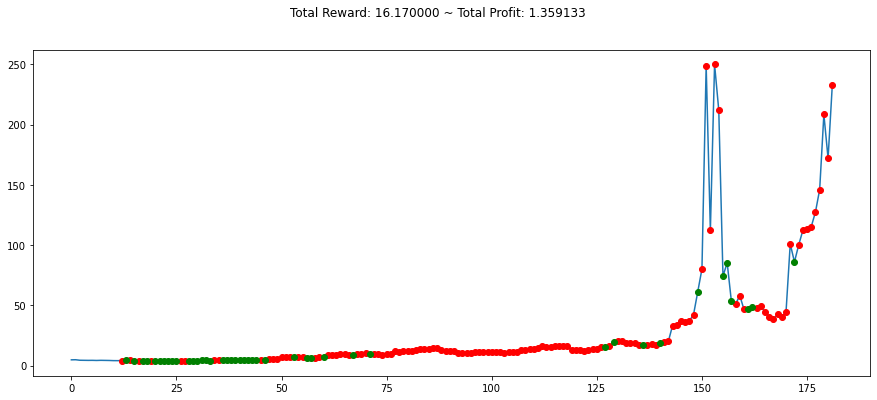

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()